# simpleVAE

A simple self-contained notebook looking at the implementation of a VAE, applied on MNIST. First we look at an unconditioned VAE, then a VAE conditioned on the target value as well.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

### Download and check dataset

Number of observations: 60000
Number of features: 28
Number of classes: 60000


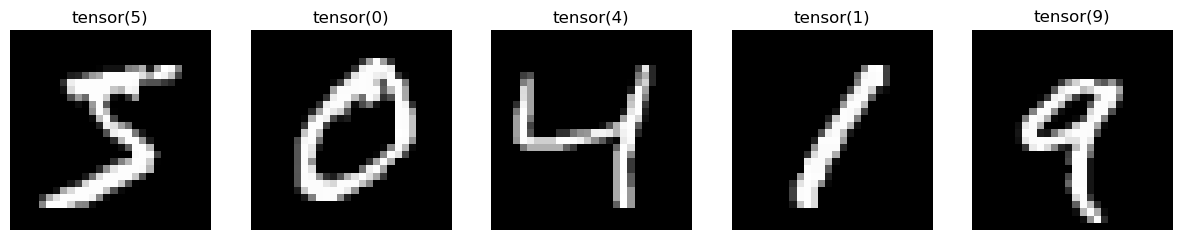

In [2]:
# Get MNIST dataf
from src.mnist_data import MNISTDataset
dataset = MNISTDataset(data_dir='data', transform=None) # MNIST with flattened vector representations

# Print some general stats about the dataset and its observations
print('Number of observations:', len(dataset))
print('Number of features:', len(dataset[0][0]))
print('Number of classes:', len(set(dataset.y)))

# Plot some examples
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(dataset[i][0].reshape(28, 28), cmap='gray')
    axs[i].set_title(dataset.y[i])
    axs[i].axis('off')
plt.show()

### Lets construct a simple VAE for MNIST

In [3]:

# Construct a simple VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.mu = nn.Linear(64, latent_dim)
        self.var = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Softplus()
        )
        
    def forward(self, x):
        # Encode
        x = x.view(-1, 28*28)
        h = self.encoder(x)
        mu = self.mu(h)
        var = self.var(h)
        z = mu + (torch.randn_like(var) * torch.exp(0.5 * var)) # reparameterisation trick
        
        # Decode
        x_recon = self.decoder(z)
        return x_recon, mu, var
    
    def loss(self, x, x_recon, mu, var):
        # Reconstruction loss
        recon_loss = torch.sum((x - x_recon)**2)
        
        # KL divergence
        kl_loss = -0.5 * torch.sum(1 + var - mu**2 - torch.exp(var))
        
        return recon_loss + kl_loss 

#### Train the VAE

/tmp/ipykernel_8626/3442298380.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Epoch 1/1000, Loss: 61449433088.0
Epoch 2/1000, Loss: 61831024640.0
Epoch 3/1000, Loss: 61543297024.0
Epoch 4/1000, Loss: 61222301696.0
Epoch 5/1000, Loss: 60671156224.0
Epoch 6/1000, Loss: 59640688640.0
Epoch 7/1000, Loss: 57908293632.0
Epoch 8/1000, Loss: 54937772032.0
Epoch 9/1000, Loss: 50443493376.0
Epoch 10/1000, Loss: 47380209664.0
Epoch 11/1000, Loss: 43040485376.0
Epoch 12/1000, Loss: 40578850816.0
Epoch 13/1000, Loss: 38570672128.0
Epoch 14/1000, Loss: 37314580480.0
Epoch 15/1000, Loss: 36769931264.0
Epoch 16/1000, Loss: 36048830464.0
Epoch 17/1000, Loss: 35898163200.0
Epoch 18/1000, Loss: 35646124032.0
Epoch 19/1000, Loss: 35488489472.0
Epoch 20/1000, Loss: 35566026752.0
Epoch 21/1000, Loss: 35295150080.0
Epoch 22/1000, Loss: 35213164544.0
Epoch 23/1000, Loss: 35347554304.0
Epoch 24/1000, Loss: 35212910592.0
Epoch 25/1000, Loss: 35411652608.0
Epoch 26/1000, Loss: 35200942080.0
Epoch 27/1000, Loss: 35126677504.0
Epoch 28/1000, Loss: 35237285888.0
Epoch 29/1000, Loss: 35272482

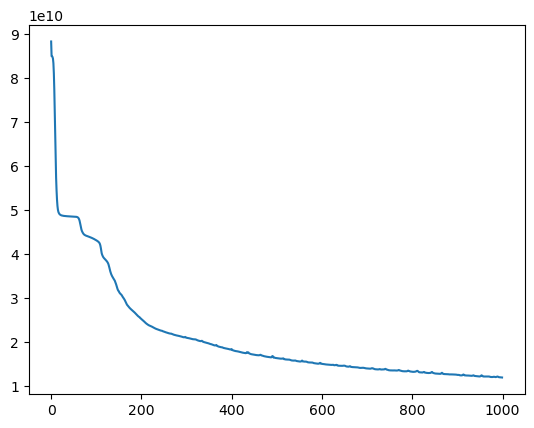

In [4]:
# Train the VAE with stochastic mini-batch gradient descent
latent_dim = 64
vae = VAE(input_dim=784, latent_dim=latent_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16384, shuffle=True)
losses = []

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae.to(device)

num_epochs = 1000
for epoch in range(num_epochs):
    num_batches = 0
    epoch_loss = 0
    for x, y in dataloader:
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x_recon, mu, var = vae(x)
        x_recon = x_recon.view(-1, 28, 28)
        loss = vae.loss(x, x_recon, mu, var)
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_batches += 1
    epoch_loss /= num_batches
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Plot the loss
plt.plot(losses)

### Generate some plots from random Gaussian samples

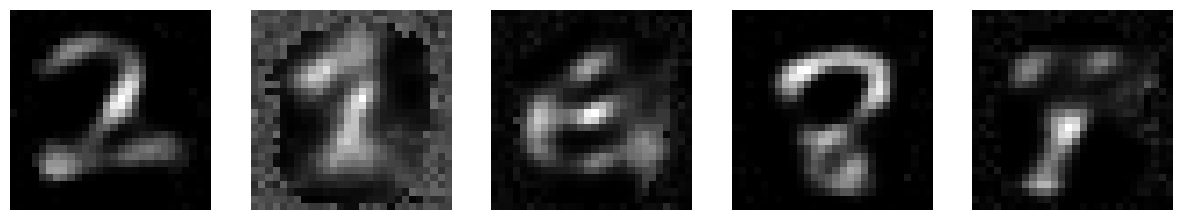

In [5]:
# Generate some samples you may run this cell multiple times to see different samples
vae.eval()
z = torch.randn(5, latent_dim).to(device)
x_recon = vae.decoder(z).view(-1, 28, 28).detach().cpu().numpy()
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(x_recon[i], cmap='gray')
    axs[i].axis('off')
plt.show()


/tmp/ipykernel_8626/3442456010.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


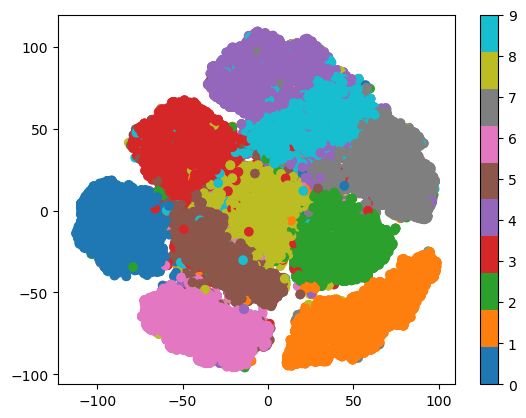

In [6]:
# Make T-SNE plot of the latent space
from sklearn.manifold import TSNE
vae.eval()
x = dataset.x
y = dataset.y
x = torch.tensor(x, dtype=torch.float32).to(device)
x_recon, mu, var = vae(x)
z = mu.detach().cpu().numpy()

z_embedded = TSNE(n_components=2).fit_transform(z)
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=y, cmap='tab10')
plt.colorbar()
plt.show()


# Conditional VAE (C-VAE)

In the following bit of code we will extend the VAE to be conditioned on the target

In [7]:
# Conditional VAE
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_classes):
        super(ConditionalVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.mu = nn.Linear(64, latent_dim)
        self.var = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Softplus()
        )
        
    def forward(self, x, y):
        # Encode
        x = x.view(-1, 28*28)
        h = torch.cat([x, y], dim=1)
        h = self.encoder(h)
        mu = self.mu(h)
        var = self.var(h)
        z = mu + (torch.randn_like(var) * torch.exp(0.5 * var)) # reparameterisation trick
        
        # Decode
        h = torch.cat([z, y], dim=1)
        x_recon = self.decoder(h)
        return x_recon, mu, var
    
    def loss(self, x, x_recon, mu, var):
        # Reconstruction loss
        recon_loss = torch.sum((x - x_recon)**2)
        
        # KL divergence
        kl_loss = -0.5 * torch.sum(1 + var - mu**2 - torch.exp(var))
        
        return recon_loss + kl_loss

#### Train the CVAE (look out for the additional class input)

/tmp/ipykernel_8626/1023998489.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)
/tmp/ipykernel_8626/1023998489.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).to(device)


Epoch 1/1000, Loss: 61494964224.0
Epoch 2/1000, Loss: 61352308736.0
Epoch 3/1000, Loss: 61308731392.0
Epoch 4/1000, Loss: 60836352000.0
Epoch 5/1000, Loss: 59510800384.0
Epoch 6/1000, Loss: 57278451712.0
Epoch 7/1000, Loss: 56161828864.0
Epoch 8/1000, Loss: 53360967680.0
Epoch 9/1000, Loss: 49672015872.0
Epoch 10/1000, Loss: 46472699904.0
Epoch 11/1000, Loss: 43301789696.0
Epoch 12/1000, Loss: 40539308032.0
Epoch 13/1000, Loss: 38882287616.0
Epoch 14/1000, Loss: 37714948096.0
Epoch 15/1000, Loss: 37072896000.0
Epoch 16/1000, Loss: 36336492544.0
Epoch 17/1000, Loss: 36014374912.0
Epoch 18/1000, Loss: 35724976128.0
Epoch 19/1000, Loss: 35695570944.0
Epoch 20/1000, Loss: 35689553920.0
Epoch 21/1000, Loss: 35586506752.0
Epoch 22/1000, Loss: 35653328896.0
Epoch 23/1000, Loss: 35466170368.0
Epoch 24/1000, Loss: 35395895296.0
Epoch 25/1000, Loss: 35468926976.0
Epoch 26/1000, Loss: 35534557184.0
Epoch 27/1000, Loss: 35389460480.0
Epoch 28/1000, Loss: 35321364480.0
Epoch 29/1000, Loss: 35437432

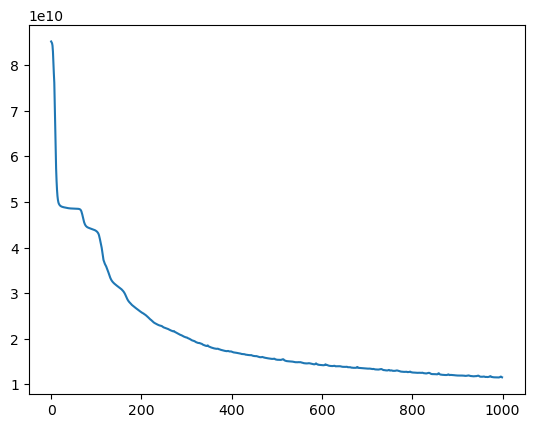

In [8]:
# Train the VAE with stochastic mini-batch gradient descent
latent_dim = 64
cvae = ConditionalVAE(input_dim=784, latent_dim=latent_dim, num_classes=10)
optimizer = torch.optim.Adam(cvae.parameters(), lr=3e-4)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16384, shuffle=True)
losses = []

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cvae.to(device)

num_epochs = 1000
for epoch in range(num_epochs):
    num_batches = 0
    epoch_loss = 0
    for x, y in dataloader:
        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).to(device)
        x_recon, mu, var = cvae(x, y)
        x_recon = x_recon.view(-1, 28, 28)
        loss = cvae.loss(x, x_recon, mu, var)
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_batches += 1
    epoch_loss /= num_batches
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Plot the loss
plt.plot(losses)


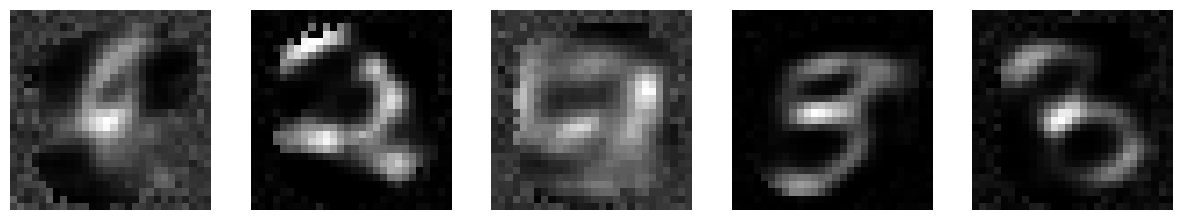

In [9]:
# Generate some samples you may run this cell multiple times to see different samples
cvae.eval()
z = torch.randn(5, latent_dim).to(device)
y = torch.nn.functional.one_hot(torch.tensor([4, 4, 4, 4, 4]), num_classes=10).to(device)
x_recon = cvae.decoder(torch.cat([z, y], dim=1)).view(-1, 28, 28).detach().cpu().numpy()
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(x_recon[i], cmap='gray')
    axs[i].axis('off')
plt.show()


/tmp/ipykernel_8626/2923323321.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)
/tmp/ipykernel_8626/2923323321.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).to(device)


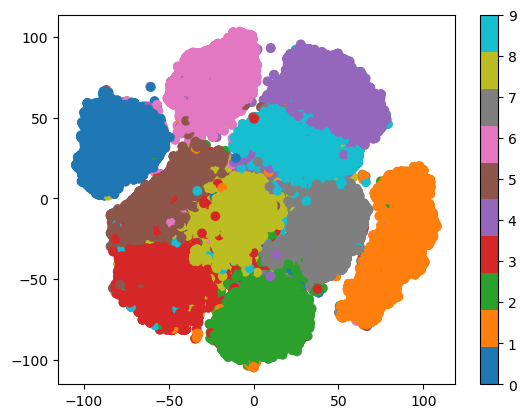

In [10]:
# Make T-SNE plot of the latent space
cvae.eval()
x = dataset.x
y = dataset.y
x = torch.tensor(x, dtype=torch.float32).to(device)
y = torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).to(device)
x_recon, mu, var = cvae(x, y)
z = mu.detach().cpu().numpy()

z_embedded = TSNE(n_components=2).fit_transform(z)
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=dataset.y, cmap='tab10')
plt.colorbar()
plt.show()
